In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('GPU:', torch.cuda.get_device_name(0))

GPU: Tesla T4


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Load the training dataset into a pandas dataframe.
df_train = pd.read_csv("drive/MyDrive/NLP/small_snli_train.tsv", sep='\t')

print('Number of training samples:',df_train.shape[0])

df_train.sample(5)

Number of training samples: 20000


,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
8276,neutral,( Wrestlers ( ( grapple ( on ( the floor ) ) )...,( ( ( Two wrestlers ) ( competing ( for ( the ...,(ROOT (S (INTJ (UH Wrestlers)) (VP (VB grapple...,(ROOT (NP (NP (CD Two) (NNS wrestlers)) (VP (V...,Wrestlers grapple on the floor.,Two wrestlers competing for the championship b...,8111420340.jpg#4,8111420340.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
16558,contradiction,( ( A man ) ( ( ( rides ( his ( dirt bike ) ) ...,( ( A girl ) ( ( is ( dancing ballet ) ) . ) ),(ROOT (S (NP (DT A) (NN man)) (VP (VBD rides) ...,(ROOT (S (NP (DT A) (NN girl)) (VP (VBZ is) (V...,A man rides his dirt bike through the woods.,A girl is dancing ballet.,3615730936.jpg#4,3615730936.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
18711,contradiction,"( Runner ( ( ( ( named Kim ) , ) ( running ( i...",( Kim ( ( walks ( to ( ( the ( bus stop ) ) ( ...,(ROOT (S (NP (NNP Runner)) (VP (VBD named) (NP...,(ROOT (S (NP (NNP Kim)) (VP (VBZ walks) (PP (T...,"Runner named Kim, running in the street.",Kim walks to the bus stop over the mountain.,6320815265.jpg#4,6320815265.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
4029,entailment,( There ( ( are ( ( two guys ) ( on ( motorcyc...,( ( Two men ) ( ( are ( ( riding motorcycles )...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NP...,(ROOT (S (NP (CD Two) (NNS men)) (VP (VBP are)...,There are two guys on motorcycles while a crow...,Two men are riding motorcycles in front of a c...,2377496811.jpg#0,2377496811.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
18131,contradiction,( ( a ( woman playing ) ) ( ( volleyball ( wea...,( A ( man ( ( ( tossing ( a volleyball ) ) aro...,(ROOT (S (NP (DT a) (NN woman) (NN playing)) (...,(ROOT (FRAG (NP (DT A) (NN man) (S (VP (VBG to...,a woman playing volleyball wearing a neon swim...,A man tossing a volleyball around by himself,6926512292.jpg#3,6926512292.jpg#3r1c,contradiction,NaN,NaN,NaN,NaN


In [ ]:
# Load the dev dataset into a pandas dataframe.
df_dev = pd.read_csv("drive/MyDrive/NLP/snli_dev.tsv", sep='\t')

print('Number of dev samples:',df_dev.shape[0])

Number of dev samples: 10000


In [ ]:
# Load the test dataset into a pandas dataframe.
df_test = pd.read_csv("drive/MyDrive/NLP/snli_test.tsv", sep='\t')

print('Number of test samples:',df_test.shape[0])

Number of test samples: 10000


In [ ]:
df_train.shape

(20000, 14)

In [ ]:
df_train['gold_label'].value_counts()

contradiction    7500
neutral          7000
entailment       5500
Name: gold_label, dtype: int64

In [ ]:
df_dev['gold_label'].value_counts()

entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: gold_label, dtype: int64

In [ ]:
df_test['gold_label'].value_counts()

entailment       3368
contradiction    3237
neutral          3219
-                 176
Name: gold_label, dtype: int64

In [ ]:
#Discarding the data samples with gold_label as "-" form dev and test data

df_dev = df_dev.loc[df_dev["gold_label"] != "-"]

df_test = df_test.loc[df_test["gold_label"] != "-"]

print("gold_label value counts of dev: \n", df_dev["gold_label"].value_counts())
print("")
print("gold_label value counts of test: \n", df_test['gold_label'].value_counts())

gold_label value counts of dev: 
 entailment       3329
contradiction    3278
neutral          3235
Name: gold_label, dtype: int64

gold_label value counts of test: 
 entailment       3368
contradiction    3237
neutral          3219
Name: gold_label, dtype: int64


In [ ]:
labels = list(df_train["gold_label"].unique())
count_labels_train = []
count_labels_dev = []
count_labels_test = []

for i in labels:
  count_labels_train.append(len(df_train.loc[df_train['gold_label'] == i]))
  count_labels_dev.append(len(df_dev.loc[df_dev['gold_label'] == i]))
  count_labels_test.append(len(df_test.loc[df_test['gold_label'] == i]))

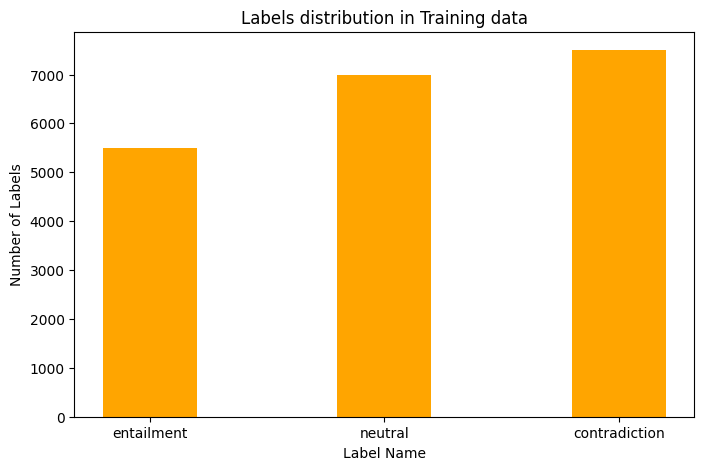

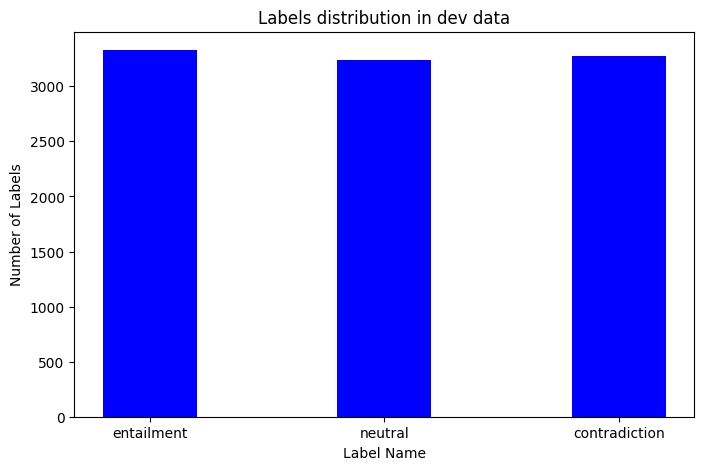

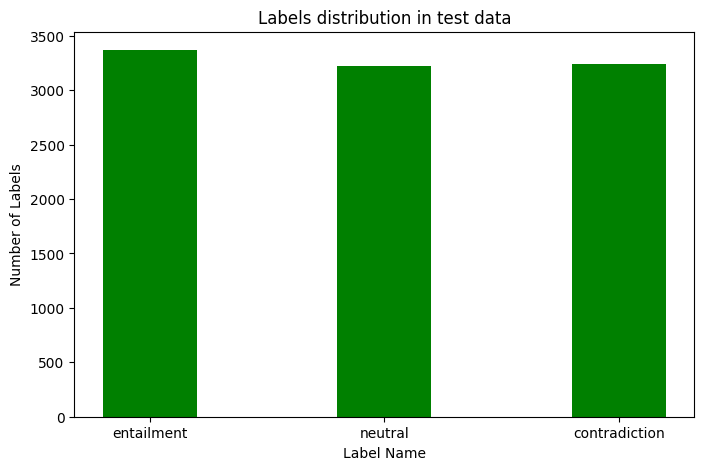

In [ ]:
#Bar Chart of Label Distribution
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,5))

# creating the bar plot for training data
plt.bar(labels, count_labels_train, color ='orange', width = 0.4)

plt.xlabel("Label Name")
plt.ylabel("Number of Labels")
plt.title("Labels distribution in Training data")

fig = plt.figure(figsize = (8, 5))

# creating the bar plot for dev data
plt.bar(labels, count_labels_dev, color ='blue', width = 0.4)

plt.xlabel("Label Name")
plt.ylabel("Number of Labels")
plt.title("Labels distribution in dev data")

fig = plt.figure(figsize = (8, 5))

# creating the bar plot for test data
plt.bar(labels, count_labels_test, color ='green', width = 0.4)

plt.xlabel("Label Name")
plt.ylabel("Number of Labels")
plt.title("Labels distribution in test data")




plt.show()



In [ ]:
# Define a mapping dictionary
mapping = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

# Apply the mapping to the 'Category' column
df_train['gold_label'] = df_train['gold_label'].map(mapping)

df_dev['gold_label'] = df_dev['gold_label'].map(mapping)



In [ ]:
# Get the lists of sentences and their labels.
sentences_1_train = df_train.sentence1.values
sentences_2_train = df_train.sentence2.values
sentences_1_dev = df_dev.sentence1.values
sentences_2_dev = df_dev.sentence2.values
labels_train = (df_train.gold_label.values)
labels_dev = (df_dev.gold_label.values)


In [ ]:
#Tokenization

In [ ]:
from transformers import RobertaTokenizer

# Load the RoBERTa tokenizer.
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Loading RoBERTa tokenizer...


In [ ]:
# Print the original sentence.
print(' Original_sentence1: ', sentences_1_train[0])

print(' Original_sentence2: ', sentences_2_train[0])

# Print the sentence split into tokens.
print('Tokenized_sentence1: ', tokenizer.tokenize(sentences_1_train[0]))

print('Tokenized_sentence2: ', tokenizer.tokenize(sentences_2_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs_sentence1: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_1_train[0])))
print('Token IDs_sentence2: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_2_train[0])))

 Original_sentence1:  A person on a horse jumps over a broken down airplane.
 Original_sentence2:  A person is outdoors, on a horse.
Tokenized_sentence1:  ['A', 'Ġperson', 'Ġon', 'Ġa', 'Ġhorse', 'Ġjumps', 'Ġover', 'Ġa', 'Ġbroken', 'Ġdown', 'Ġairplane', '.']
Tokenized_sentence2:  ['A', 'Ġperson', 'Ġis', 'Ġoutdoors', ',', 'Ġon', 'Ġa', 'Ġhorse', '.']
Token IDs_sentence1:  [250, 621, 15, 10, 5253, 13855, 81, 10, 3187, 159, 16847, 4]
Token IDs_sentence2:  [250, 621, 16, 13384, 6, 15, 10, 5253, 4]


In [ ]:
#Calculating maximum possible length
max_len = 0

# For every sentence...
for i in range(len(df_train)):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sentences_1_train[i],sentences_2_train[i], add_special_tokens=True)




    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  95


In [ ]:
# Tokenization and map the tokens to thier word IDs.


def Tokenize(data,sent_1,sent_2):
  input_ids = []
  attention_masks = []

  # For every sentence...
  for i in range(len(data)):

      premise = sent_1[i]
      hypothesis = sent_2[i]
      encoded_dict = tokenizer.encode_plus(
                          premise,
                          hypothesis,
                          add_special_tokens = True,
                          max_length = 128,
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt',
                    )


      input_ids.append(encoded_dict['input_ids'])


      attention_masks.append(encoded_dict['attention_mask'])



  return input_ids, attention_masks

In [ ]:
# Convert the lists into tensors.
input_ids_train,attention_masks_train =  Tokenize(df_train,sentences_1_train,sentences_2_train)
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

# Print sentence 0, now as a list of IDs.
print('Token IDs:', input_ids_train[0])

## Convert the lists into tensors.
input_ids_dev,attention_masks_dev =  Tokenize(df_dev,sentences_1_dev,sentences_2_dev)
input_ids_dev = torch.cat(input_ids_dev, dim=0)
attention_masks_dev = torch.cat(attention_masks_dev, dim=0)
labels_dev = torch.tensor(labels_dev)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Token IDs: tensor([    0,   250,   621,    15,    10,  5253, 13855,    81,    10,  3187,
          159, 16847,     4,     2,     2,   250,   621,    16, 13384,     6,
           15,    10,  5253,     4,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,    

In [ ]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)

dev_dataset = TensorDataset(input_ids_dev, attention_masks_dev, labels_dev)

In [ ]:
#Creating Data Loaders
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )
validation_dataloader = DataLoader(
            dev_dataset,
            sampler = SequentialSampler(dev_dataset),
            batch_size = batch_size
        )

In [ ]:
#Training

In [ ]:
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels = 3,

    output_attentions = False,
    output_hidden_states = False,
)

model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 1e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5


total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''

    elapsed_rounded = int(round((elapsed)))


    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    #Training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    t0 = time.time()


    total_train_loss = 0


    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):


        if step % 40 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)


            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


        optimizer.step()


        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    #Validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        with torch.no_grad():


            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)


        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculating the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)


    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    625.    Elapsed: 0:00:25.
  Batch    80  of    625.    Elapsed: 0:00:48.
  Batch   120  of    625.    Elapsed: 0:01:11.
  Batch   160  of    625.    Elapsed: 0:01:35.
  Batch   200  of    625.    Elapsed: 0:01:59.
  Batch   240  of    625.    Elapsed: 0:02:23.
  Batch   280  of    625.    Elapsed: 0:02:47.
  Batch   320  of    625.    Elapsed: 0:03:11.
  Batch   360  of    625.    Elapsed: 0:03:36.
  Batch   400  of    625.    Elapsed: 0:04:00.
  Batch   440  of    625.    Elapsed: 0:04:24.
  Batch   480  of    625.    Elapsed: 0:04:48.
  Batch   520  of    625.    Elapsed: 0:05:13.
  Batch   560  of    625.    Elapsed: 0:05:37.
  Batch   600  of    625.    Elapsed: 0:06:01.

  Average training loss: 0.65
  Training epcoh took: 0:06:16

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.39
  Validation took: 0:00:59

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    625.    Elapsed: 0:00:24.
  Batch  

In [ ]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.650910,0.394441,0.856173,0:06:16,0:00:59
2,0.402704,0.357332,0.872757,0:06:18,0:00:59
3,0.327930,0.367464,0.875473,0:06:19,0:00:59
4,0.278922,0.367276,0.879915,0:06:18,0:00:59
5,0.242884,0.392252,0.879712,0:06:18,0:00:59


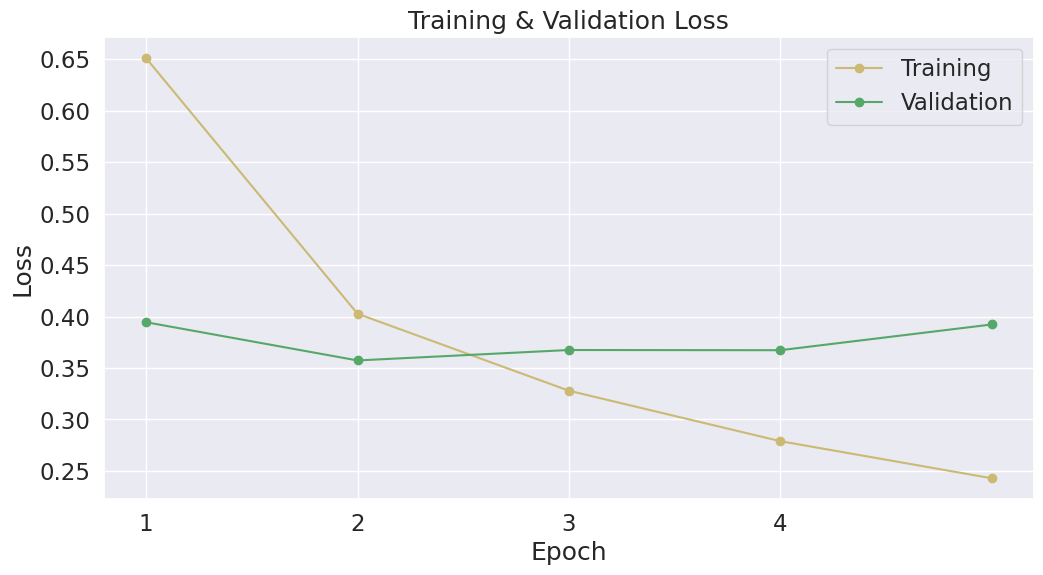

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'y-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#On Test Set

In [ ]:
# Load the test dataset into a pandas dataframe.
df_test = pd.read_csv("drive/MyDrive/NLP/snli_test.tsv", sep='\t')
df_test = df_test.loc[df_test["gold_label"] != "-"]
df_test['gold_label'] = df_test['gold_label'].map(mapping)

df_test = df_test.dropna(subset=['gold_label'])

print('Number of test samples:',df_test.shape[0])

# Create sentence and label lists
sentences_1_test = df_test.sentence1.values
sentences_2_test = df_test.sentence2.values
labels_test = df_test.gold_label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []


for i in range(len(df_test)):


    premise = sentences_1_test[i]
    hypothesis = sentences_2_test[i]
    encoded_dict = tokenizer.encode_plus(
                        premise,
                        hypothesis,
                        add_special_tokens = True,
                        max_length = 128,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                  )


    input_ids.append(encoded_dict['input_ids'])


    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test samples: 9824


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)


  b_input_ids, b_input_mask, b_labels = batch


  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  pred_labels = np.argmax(logits, axis=1)
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(pred_labels.tolist())
  true_labels.extend(label_ids.tolist())

print('    DONE.')

Predicting labels for 9,824 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import classification_report

result_report= classification_report(true_labels, predictions, digits=3)
print(result_report)

              precision    recall  f1-score   support

           0      0.902     0.881     0.891      3368
           1      0.841     0.847     0.844      3219
           2      0.893     0.909     0.901      3237

    accuracy                          0.879      9824
   macro avg      0.879     0.879     0.879      9824
weighted avg      0.879     0.879     0.879      9824



In [ ]:
import json
result_report_dict= classification_report(true_labels, predictions, digits=3,output_dict=True)
json_file_path = 'drive/MyDrive/NLP/results_1227628547.json'
with open(json_file_path, 'w') as json_file:
    json.dump(result_report_dict, json_file, indent=4)

print(f"Classification report saved as {json_file_path}")

Classification report saved as drive/MyDrive/NLP/results_1227628547.json


In [ ]:
import os

output_dir = './drive/MyDrive/NLP/model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)


model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./drive/MyDrive/NLP/model_save/


('./drive/MyDrive/NLP/model_save/tokenizer_config.json',
 './drive/MyDrive/NLP/model_save/special_tokens_map.json',
 './drive/MyDrive/NLP/model_save/vocab.json',
 './drive/MyDrive/NLP/model_save/merges.txt',
 './drive/MyDrive/NLP/model_save/added_tokens.json')